In [12]:
# getting mocap data
from support.funcs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_mocap,starttime=read_df_csv(r'C:\Users\arpan\OneDrive\Documents\internship\mocapcsv\arpan_t2.csv')

# converting to epoch time
epoch_time = starttime.timestamp() 
time=df_mocap['seconds'].to_numpy()
time=time+epoch_time
df_mocap.insert(1,'epoch_time',time)
df_mocap.columns

# getting mpipe data
df_mpipe=pd.read_csv('mpipe.csv')
df_mpipe

# converting mpipe to mocap frame
rotmat=[]
org=[]
with open(r'C:\Users\arpan\OneDrive\Documents\internship\D435_rotmat.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        x=x.replace(']','')
        x=x.replace('[','')
        line=x.split(' ')
        while ' ' in line:
            line=line.remove(' ')
        #k_rotmat.append([float(x)])
        while '' in line:
            ind=line.index('')
            line.pop(ind)
        x=[]
        for i in line:
            x.append(float(i))
        rotmat.append(x)
    rotmat=np.array(rotmat)

with open(r'C:\Users\arpan\OneDrive\Documents\internship\D435_org.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        x=x.replace(']','')
        x=x.replace('[','')
        org.append([float(x)])
    k_org=np.array(org)

# print(rotmat)
# print(org)

def frame_con(point,rotmat,org):
    point=np.array(point)
    point=point.reshape(3,1)
    point=point-org 
    point=np.matmul(rotmat.T,point)
    return point

for index,j in df_mpipe.iterrows():
    for k in range(1,1+7*3,3):
        point=[]
        for p in range(k,k+3):
            point.append(j[p])
        converted_point=frame_con(point,rotmat,org)
        # print(converted_point)
        for o in range(3):
            df_mpipe.iloc[index,k+o]=converted_point[o]

# occlusion based on limb length
df_limb=pd.read_csv('limbl.csv')
olu,oll,oru,orl,oss=[0],[0],[0],[0],[0]
th=0.10 # 10cm
for i in range(1,len(df_limb)):
    if abs(df_limb['lu'][i]-df_limb['lu'].mean())>th:
        olu.append(1)
    else:
        olu.append(0)
    if abs(df_limb['ll'][i]-df_limb['ll'].mean())>th:
        oll.append(1)
    else:
        oll.append(0)
    if abs(df_limb['ru'][i]-df_limb['ru'].mean())>th:
        oru.append(1)
    else:
        oru.append(0)
    if abs(df_limb['rl'][i]-df_limb['rl'].mean())>th:
        orl.append(1)
    else:
        orl.append(0)
    if abs(df_limb['ss'][i]-df_limb['ss'].mean())>th:
        oss.append(1)
    else:
        oss.append(0)

# filtering occlusion limb length
for index,j in df_mpipe.iterrows():
    
    for k in range(3):
        if oss[index]==0 and olu[index]==0:
            lsx=df_mpipe['ls_x'].iloc[index]
            lsy=df_mpipe['ls_y'].iloc[index]
            lsz=df_mpipe['ls_z'].iloc[index]
        df_mpipe['ls_x'].iloc[index]=lsx
        df_mpipe['ls_y'].iloc[index]=lsy
        df_mpipe['ls_z'].iloc[index]=lsz
        
    for k in range(3):
        if oll[index]==0 and olu[index]==0:
            lex=df_mpipe['le_x'].iloc[index]
            ley=df_mpipe['le_y'].iloc[index]
            lez=df_mpipe['le_z'].iloc[index]
        df_mpipe['le_x'].iloc[index]=lex
        df_mpipe['le_y'].iloc[index]=ley
        df_mpipe['le_z'].iloc[index]=lez

    for k in range(3):
        if oll[index]==0:
            lwx=df_mpipe['lw_x'].iloc[index]
            lwy=df_mpipe['lw_y'].iloc[index]
            lwz=df_mpipe['lw_z'].iloc[index]
        df_mpipe['lw_x'].iloc[index]=lwx
        df_mpipe['lw_y'].iloc[index]=lwy
        df_mpipe['lw_z'].iloc[index]=lwz

    for k in range(3):
        if oss[index]==0 and oru[index]==0:
            rsx=df_mpipe['rs_x'].iloc[index]
            rsy=df_mpipe['rs_y'].iloc[index]
            rsz=df_mpipe['rs_z'].iloc[index]
        df_mpipe['rs_x'].iloc[index]=rsx
        df_mpipe['rs_y'].iloc[index]=rsy
        df_mpipe['rs_z'].iloc[index]=rsz

    for k in range(3):
        if orl[index]==0 and oru[index]==0:
            rex=df_mpipe['re_x'].iloc[index]
            rey=df_mpipe['re_y'].iloc[index]
            rez=df_mpipe['re_z'].iloc[index]
        df_mpipe['re_x'].iloc[index]=rex
        df_mpipe['re_y'].iloc[index]=rey
        df_mpipe['re_z'].iloc[index]=rez

    for k in range(3):
        if orl[index]==0 and oru[index]==0:
            rwx=df_mpipe['rw_x'].iloc[index]
            rwy=df_mpipe['rw_y'].iloc[index]
            rwz=df_mpipe['rw_z'].iloc[index]
        df_mpipe['rw_x'].iloc[index]=rwx
        df_mpipe['rw_y'].iloc[index]=rwy
        df_mpipe['rw_z'].iloc[index]=rwz

def pvt(x,t):
    from scipy.signal import savgol_filter
    y=[]
    for i in x:
        y.append(i)
    # y=[i for i in y if str(i) != 'nan']
    w = savgol_filter(y,  int(len(y)/20),3)
    plt.plot(t,w)
    # plt.ylim(-1,1)
    plt.xlabel('time(s)')

    

In [13]:
# calibration frame
f=False
for ind,val in enumerate(df_mpipe['epoch_time'].tolist()):
    for i,v in enumerate(df_mocap['epoch_time'].tolist()):
        if v==val:
            print(ind,i,val)
            mpipe_cf=ind
            mocap_cf=i
            f=True
            break
    if f:
        break

print('\n-----------------------\n')

for ind,val in enumerate(df_mpipe['epoch_time'].tolist()):
    for i,v in enumerate(df_mocap['epoch_time'].tolist()):
        if v==val:
            print(ind,i,val)

if not f:
    mpipe_cf=20
    mocap_cf=20


-----------------------



In [14]:
# calibrate the frame shoulder frame of reference

mpiperrf=find_orthogonal_frame([df_mpipe['re_x'][mpipe_cf]-df_mpipe['rs_x'][mpipe_cf],df_mpipe['re_y'][mpipe_cf]-df_mpipe['rs_y'][mpipe_cf],df_mpipe['re_z'][mpipe_cf]-df_mpipe['rs_z'][mpipe_cf]],
                               [df_mpipe['rw_x'][mpipe_cf]-df_mpipe['re_x'][mpipe_cf],df_mpipe['rw_y'][mpipe_cf]-df_mpipe['re_y'][mpipe_cf],df_mpipe['rw_z'][mpipe_cf]-df_mpipe['re_z'][mpipe_cf]])

mpipelrf=find_orthogonal_frame([df_mpipe['le_x'][mpipe_cf]-df_mpipe['ls_x'][mpipe_cf],df_mpipe['le_y'][mpipe_cf]-df_mpipe['ls_y'][mpipe_cf],df_mpipe['le_z'][mpipe_cf]-df_mpipe['ls_z'][mpipe_cf]],
                               [df_mpipe['lw_x'][mpipe_cf]-df_mpipe['le_x'][mpipe_cf],df_mpipe['lw_y'][mpipe_cf]-df_mpipe['le_y'][mpipe_cf],df_mpipe['lw_z'][mpipe_cf]-df_mpipe['le_z'][mpipe_cf]])

mpipetrf=find_tr_frame([df_mpipe['rs_x'][mpipe_cf],df_mpipe['rs_y'][mpipe_cf],df_mpipe['rs_z'][mpipe_cf]],
                       [df_mpipe['ls_x'][mpipe_cf],df_mpipe['ls_y'][mpipe_cf],df_mpipe['ls_z'][mpipe_cf]],
                       [df_mpipe['tr_x'][mpipe_cf],df_mpipe['tr_y'][mpipe_cf],df_mpipe['tr_z'][mpipe_cf]])

mocaprrf=find_orthogonal_frame([df_mocap['re_x'][mocap_cf]-df_mocap['rs_x'][mocap_cf],df_mocap['re_y'][mocap_cf]-df_mocap['rs_y'][mocap_cf],df_mocap['re_z'][mocap_cf]-df_mocap['rs_z'][mocap_cf]],
                               [df_mocap['rw_x'][mocap_cf]-df_mocap['re_x'][mocap_cf],df_mocap['rw_y'][mocap_cf]-df_mocap['re_y'][mocap_cf],df_mocap['rw_z'][mocap_cf]-df_mocap['re_z'][mocap_cf]])

mocaplrf=find_orthogonal_frame([df_mocap['le_x'][mocap_cf]-df_mocap['ls_x'][mocap_cf],df_mocap['le_y'][mocap_cf]-df_mocap['ls_y'][mocap_cf],df_mocap['le_z'][mocap_cf]-df_mocap['ls_z'][mocap_cf]],
                               [df_mocap['lw_x'][mocap_cf]-df_mocap['le_x'][mocap_cf],df_mocap['lw_y'][mocap_cf]-df_mocap['le_y'][mocap_cf],df_mocap['lw_z'][mocap_cf]-df_mocap['le_z'][mocap_cf]])

mocaptrf=find_tr_frame([df_mocap['rs_x'][mocap_cf],df_mocap['rs_y'][mocap_cf],df_mocap['rs_z'][mocap_cf]],
                       [df_mocap['ls_x'][mocap_cf],df_mocap['ls_y'][mocap_cf],df_mocap['ls_z'][mocap_cf]],
                       [df_mocap['tr_x'][mocap_cf],df_mocap['tr_y'][mocap_cf],df_mocap['tr_z'][mocap_cf]])

In [15]:
# calculating euler angles for trunk yzx-flexion/extension,abduction/adduction,internal/external rotation

mpipettheta1,mpipettheta2,mpipettheta3=[],[],[]

for i in range(len(df_mpipe['epoch_time'].tolist())):
    newmat=find_tr_frame([df_mpipe['rs_x'][i],df_mpipe['rs_y'][i],df_mpipe['rs_z'][i]],
                         [df_mpipe['ls_x'][i],df_mpipe['ls_y'][i],df_mpipe['ls_z'][i]],
                         [df_mpipe['tr_x'][i],df_mpipe['tr_y'][i],df_mpipe['tr_z'][i]])  

    rotmat=find_rotation_matrix(mpipetrf,newmat)
    mpiperthetas=rotation_angles(rotmat)

    mpipettheta1.append(mpiperthetas[0])
    mpipettheta2.append(mpiperthetas[1])
    mpipettheta3.append(-mpiperthetas[2])  

mocapttheta1,mocapttheta2,mocapttheta3=[],[],[]

for i in range(len(df_mocap['epoch_time'].tolist())):
    newmat=find_tr_frame([df_mocap['rs_x'][i],df_mocap['rs_y'][i],df_mocap['rs_z'][i]],
                         [df_mocap['ls_x'][i],df_mocap['ls_y'][i],df_mocap['ls_z'][i]],
                         [df_mocap['tr_x'][i],df_mocap['tr_y'][i],df_mocap['tr_z'][i]])  

    rotmat=find_rotation_matrix(mocaptrf,newmat)
    mocaprthetas=rotation_angles(rotmat)

    mocapttheta1.append(mocaprthetas[0])
    mocapttheta2.append(mocaprthetas[1])
    mocapttheta3.append(-mocaprthetas[2])  


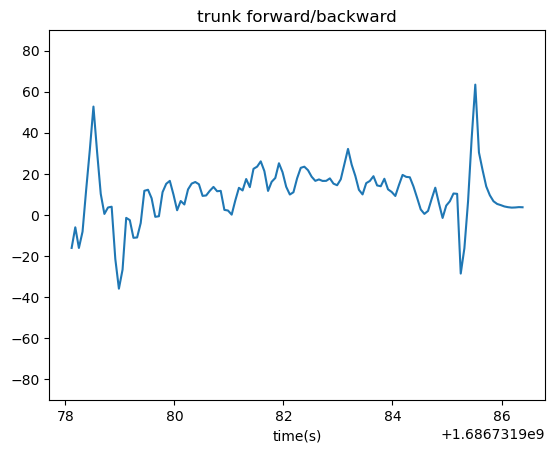

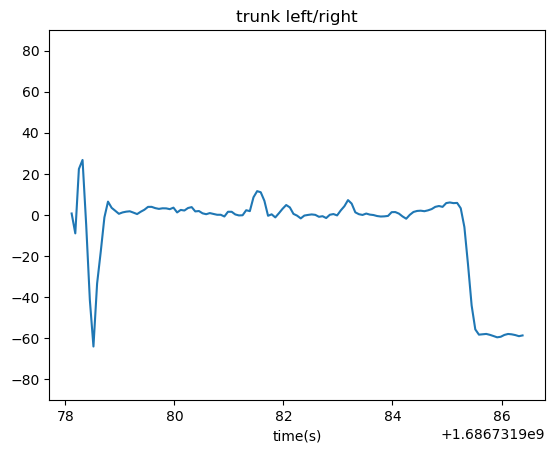

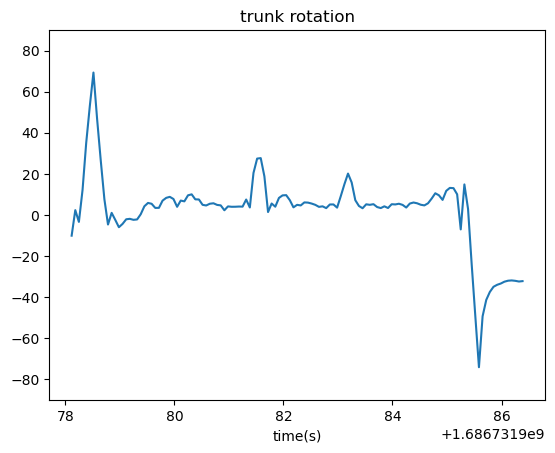

In [16]:
pvt(mpipettheta1,df_mpipe['epoch_time'])
# pvt(mocapttheta1,df_mocap['epoch_time'])
# plt.legend(['mediapipe','mocap'])
plt.title('trunk forward/backward')
plt.ylim(-90,90)
plt.show()

# print('RMSE of forward/backward: ',RMSE(mocapttheta1,mpipettheta1,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))

pvt(mpipettheta2,df_mpipe['epoch_time'])
# pvt(mocapttheta2,df_mocap['epoch_time'])
# plt.legend(['mediapipe','mocap'])
plt.title('trunk left/right')
plt.ylim(-90,90)
plt.show()

# print('RMSE of left/right: ',RMSE(mocapttheta2,mpipettheta2,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))

pvt(mpipettheta3,df_mpipe['epoch_time'].tolist())
# pvt(mocapttheta3,df_mocap['epoch_time'].tolist())
# plt.legend(['mediapipe','mocap'])
plt.title('trunk rotation')
plt.ylim(-90,90)
plt.show()

# print('RMSE of rotation: ',RMSE(mocapttheta3,mpipettheta3,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))


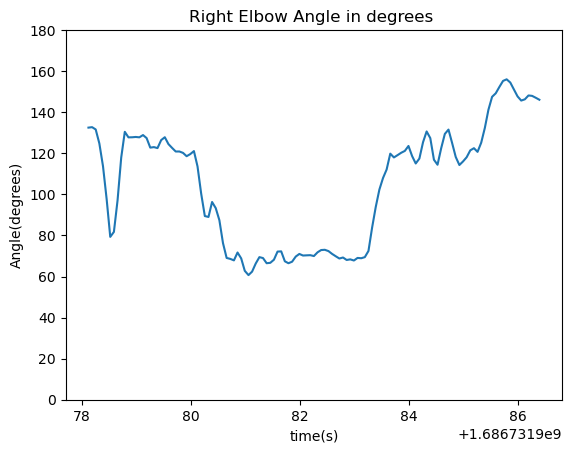

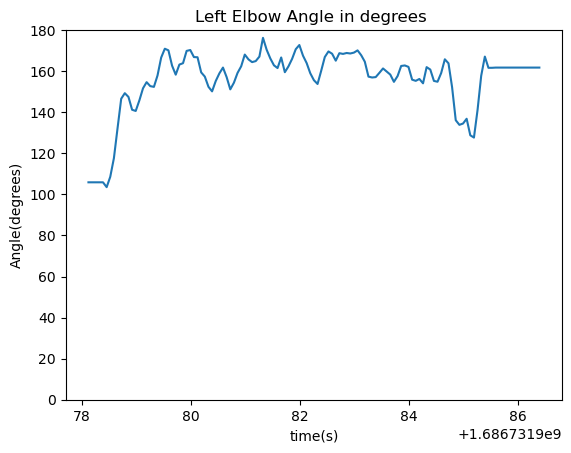

In [17]:
#calculating the elbow angle
mpipeRightElbowAngle, mocapRightElbowAngle=[],[]

for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeRightElbowAngle.append(angle3point([df_mpipe['rs_x'][i],df_mpipe['rs_y'][i],df_mpipe['rs_z'][i]],
                                            [df_mpipe['re_x'][i],df_mpipe['re_y'][i],df_mpipe['re_z'][i]],
                                            [df_mpipe['rw_x'][i],df_mpipe['rw_y'][i],df_mpipe['rw_z'][i]]))
    
for i in range(len(df_mocap['epoch_time'].tolist())):
    mocapRightElbowAngle.append(angle3point([df_mocap['rs_x'][i],df_mocap['rs_y'][i],df_mocap['rs_z'][i]],
                                            [df_mocap['re_x'][i],df_mocap['re_y'][i],df_mocap['re_z'][i]],
                                            [df_mocap['rw_x'][i],df_mocap['rw_y'][i],df_mocap['rw_z'][i]]))
    
#test graph right elbow angle wihtout occlusion
pvt(mpipeRightElbowAngle,df_mpipe['epoch_time'])
# pvt(mocapRightElbowAngle,df_mocap['epoch_time'])
plt.title('Right Elbow Angle in degrees ')
plt.xlabel('time(s)')
plt.ylabel('Angle(degrees)')
# plt.legend(['mediapipe','mocap'])
plt.ylim(0,180)
plt.show()

# print('RMSE of Right Elbow Angle:',RMSE(mocapRightElbowAngle,mpipeRightElbowAngle,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))

mpipeLeftElbowAngle, mocapLeftElbowAngle=[],[]

for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeLeftElbowAngle.append(angle3point([df_mpipe['ls_x'][i],df_mpipe['ls_y'][i],df_mpipe['ls_z'][i]],
                                           [df_mpipe['le_x'][i],df_mpipe['le_y'][i],df_mpipe['le_z'][i]],
                                           [df_mpipe['lw_x'][i],df_mpipe['lw_y'][i],df_mpipe['lw_z'][i]]))
   
for i in range(len(df_mocap['epoch_time'].tolist())):
    mocapLeftElbowAngle.append(angle3point([df_mocap['ls_x'][i],df_mocap['ls_y'][i],df_mocap['ls_z'][i]],
                                           [df_mocap['le_x'][i],df_mocap['le_y'][i],df_mocap['le_z'][i]],
                                           [df_mocap['lw_x'][i],df_mocap['lw_y'][i],df_mocap['lw_z'][i]]))
   
#test graph left elbow angle wihtout occlusion
pvt(mpipeLeftElbowAngle,df_mpipe['epoch_time'])
# pvt(mocapLeftElbowAngle,df_mocap['epoch_time'])
# plt.legend(['mediapipe','mocap'])
plt.title('Left Elbow Angle in degrees ')
plt.xlabel('time(s)')
plt.ylabel('Angle(degrees)')
plt.ylim(0,180)
plt.show()


# print('RMSE of Left Elbow Angle:',RMSE(mocapLeftElbowAngle,mpipeLeftElbowAngle,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))


In [18]:
# calculating euler angles for shoulder xzy-flexion/extension,abduction/adduction,internal/external rotation

mpipertheta1,mpipertheta2,mpipertheta3=[],[],[]
mpipeltheta1,mpipeltheta2,mpipeltheta3=[],[],[]
eath=160

for i in range(len(df_mpipe['epoch_time'].tolist())):
    newmat=find_orthogonal_frame([df_mpipe['re_x'][i]-df_mpipe['rs_x'][i],df_mpipe['re_y'][i]-df_mpipe['rs_y'][i],df_mpipe['re_z'][i]-df_mpipe['rs_z'][i]],
                                 [df_mpipe['rw_x'][i]-df_mpipe['re_x'][i],df_mpipe['rw_y'][i]-df_mpipe['re_y'][i],df_mpipe['rw_z'][i]-df_mpipe['re_z'][i]])  
    rotmat=find_rotation_matrix(mpiperrf,newmat)
    mpiperthetas=rotation_angles(rotmat)

    newmat=find_orthogonal_frame([df_mpipe['le_x'][i]-df_mpipe['ls_x'][i],df_mpipe['le_y'][i]-df_mpipe['ls_y'][i],df_mpipe['le_z'][i]-df_mpipe['ls_z'][i]],
                                 [df_mpipe['lw_x'][i]-df_mpipe['le_x'][i],df_mpipe['lw_y'][i]-df_mpipe['le_y'][i],df_mpipe['lw_z'][i]-df_mpipe['le_z'][i]])
    rotmat=find_rotation_matrix(mpipelrf,newmat)
    mpipelthetas=rotation_angles(rotmat)

    mpipertheta1.append(mpiperthetas[0])
    mpipertheta2.append(mpiperthetas[1])
    if mpipeRightElbowAngle[i]<eath:
        mpipertheta3.append(-mpiperthetas[2])  
    else:
        mpipertheta3.append(np.nan)

    mpipeltheta1.append(mpipelthetas[0])
    mpipeltheta2.append(-mpipelthetas[1])
    if mpipeLeftElbowAngle[i]<eath:
        mpipeltheta3.append(mpipelthetas[2])  
    else:
        mpipeltheta3.append(np.nan)


mocaprtheta1,mocaprtheta2,mocaprtheta3=[],[],[]
mocapltheta1,mocapltheta2,mocapltheta3=[],[],[]

for i in range(len(df_mocap['epoch_time'].tolist())):
    newmat=find_orthogonal_frame([df_mocap['re_x'][i]-df_mocap['rs_x'][i],df_mocap['re_y'][i]-df_mocap['rs_y'][i],df_mocap['re_z'][i]-df_mocap['rs_z'][i]],
                                 [df_mocap['rw_x'][i]-df_mocap['re_x'][i],df_mocap['rw_y'][i]-df_mocap['re_y'][i],df_mocap['rw_z'][i]-df_mocap['re_z'][i]])  
    rotmat=find_rotation_matrix(mocaprrf,newmat)
    mocaprthetas=rotation_angles(rotmat)

    newmat=find_orthogonal_frame([df_mocap['le_x'][i]-df_mocap['ls_x'][i],df_mocap['le_y'][i]-df_mocap['ls_y'][i],df_mocap['le_z'][i]-df_mocap['ls_z'][i]],
                                 [df_mocap['lw_x'][i]-df_mocap['le_x'][i],df_mocap['lw_y'][i]-df_mocap['le_y'][i],df_mocap['lw_z'][i]-df_mocap['le_z'][i]])
    rotmat=find_rotation_matrix(mocaplrf,newmat)
    mocaplthetas=rotation_angles(rotmat)

    mocaprtheta1.append(mocaprthetas[0])
    mocaprtheta2.append(mocaprthetas[1])
    if mocapRightElbowAngle[i]<eath:
        mocaprtheta3.append(-mocaprthetas[2])  
    else:
        mocaprtheta3.append(np.nan)


    mocapltheta1.append(mocaplthetas[0])
    mocapltheta2.append(-mocaplthetas[1])
    if mocapLeftElbowAngle[i]<eath:
        mocapltheta3.append(mocaplthetas[2])  
    else:
        mocapltheta3.append(np.nan)

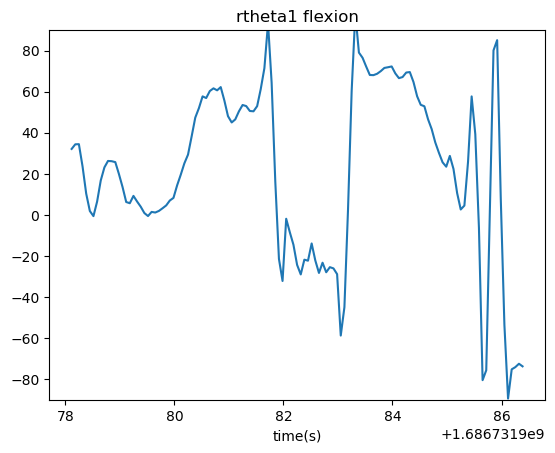

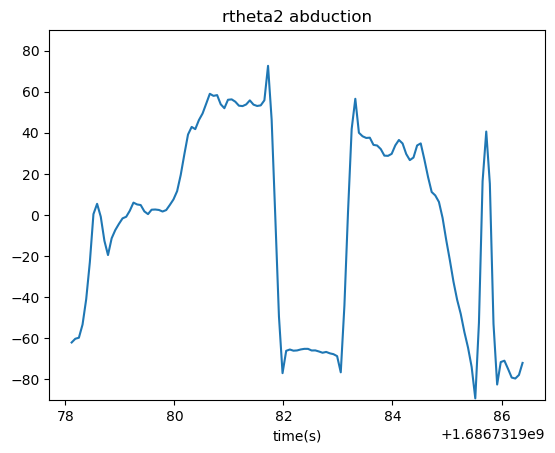

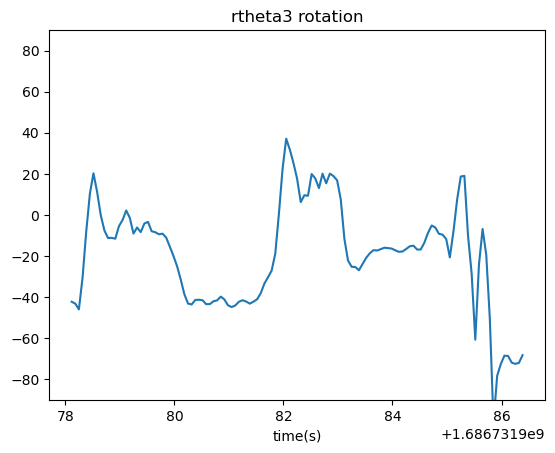

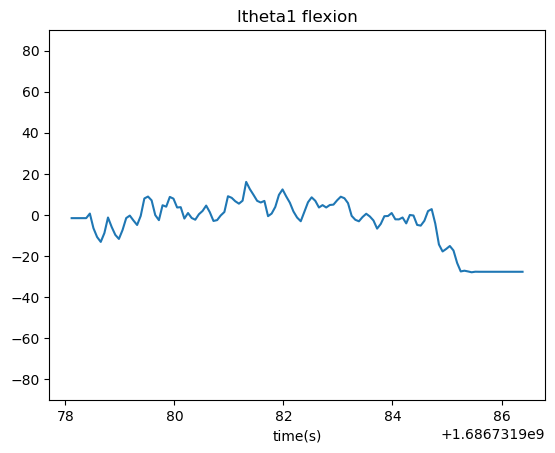

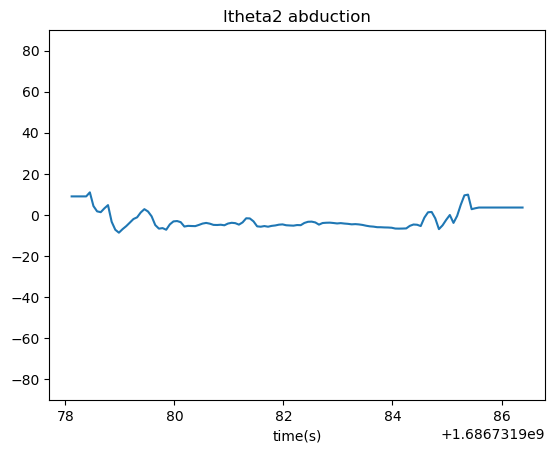

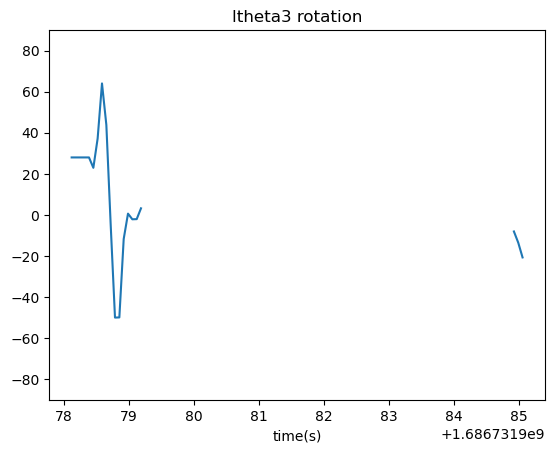

In [19]:
pvt(mpipertheta1,df_mpipe['epoch_time'])
# pvt(mocaprtheta1,df_mocap['epoch_time'])
# plt.legend(['mediapipe','mocap'])
plt.title('rtheta1 flexion')
plt.ylim(-90,90)
plt.show()

# print('RMSE of flexion/extension: ',RMSE(mocaprtheta1,mpipertheta1,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))

pvt(mpipertheta2,df_mpipe['epoch_time'])
# pvt(mocaprtheta2,df_mocap['epoch_time'])
# plt.legend(['mediapipe','mocap'])
plt.title('rtheta2 abduction')
plt.ylim(-90,90)
plt.show()

# print('RMSE of abduct/adduct: ',RMSE(mocaprtheta2,mpipertheta2,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))

pvt(mpipertheta3,df_mpipe['epoch_time'].tolist())
# pvt(mocaprtheta3,df_mocap['epoch_time'].tolist())
# plt.legend(['mediapipe','mocap'])
plt.title('rtheta3 rotation')
plt.ylim(-90,90)
plt.show()

# print('RMSE of internal/external rotation: ',RMSE(mocaprtheta3,mpipertheta3,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))

pvt(mpipeltheta1,df_mpipe['epoch_time'])
# pvt(mocapltheta1,df_mocap['epoch_time'])
# plt.legend(['mediapipe','mocap'])
plt.title('ltheta1 flexion')
plt.ylim(-90,90)
plt.show()

# print('RMSE of flexion/extension: ',RMSE(mocapltheta1,mpipeltheta1,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))

pvt(mpipeltheta2,df_mpipe['epoch_time'])
# pvt(mocapltheta2,df_mocap['epoch_time'])
# plt.legend(['mediapipe','mocap'])
plt.title('ltheta2 abduction')
plt.ylim(-90,90)
plt.show()

# print('RMSE of abduct/adduct: ',RMSE(mocapltheta2,mpipeltheta2,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))

pvt(mpipeltheta3,df_mpipe['epoch_time'].tolist())
# pvt(mocapltheta3,df_mocap['epoch_time'].tolist())
# plt.legend(['mediapipe','mocap'])
plt.title('ltheta3 rotation')
plt.ylim(-90,90)
plt.show()

# print('RMSE of internal/external rotation: ',RMSE(mocapltheta3,mpipeltheta3,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))